In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from matplotlib import cm
from skimage import color,exposure,img_as_float,measure,segmentation,io
import anndata
import scanpy as sc
import xarray

In [2]:
z_stack = 3
method = 'tacco'
ANDATA_FILE = f'/media/gambino/students_workdir/ilias/data/images/tile40/transcripts/tile_40_gt_z{z_stack}_expression_matrix_dc_{method}.h5ad'

andata = anndata.read(ANDATA_FILE)
andata.var.index = andata.var.index.str.upper()

In [3]:
image = andata.uns.get('image')
masks = andata.uns.get('masks')
transcript_coords = andata.uns.get('transcript_coordinates')

In [4]:
andata.obs = andata.obs.sort_values(by='mask_label')
andata.obs.head(3)

,mask_label,bbox,centroid-0,centroid-1,axis_major_length,axis_minor_length,area,n_genes,n_genes_by_counts,total_counts,pred_cell_type,pred_class
cell_id,,,,,,,,,,,,
7596_0_2010_93_2113,7596,"0,2010,93,2113",45.507658,2057.688285,109.680729,85.044677,7247.0,165,165,546,Stromal cells,Tumor
7597_37_3330_93_3396,7597,"37,3330,93,3396",61.828131,3364.045538,68.568696,51.853015,2723.0,99,99,258,Epithelial cells,Tumor
7598_37_3450_167_3552,7598,"37,3450,167,3552",108.106342,3506.736172,131.445293,91.276359,8877.0,198,198,736,Epithelial cells,Tumor


In [5]:
andata.obs['pred_cell_type'].value_counts()

pred_cell_type
Epithelial cells    9999
Stromal cells        987
Myeloids             630
T cells              492
B cells               21
Mast cells             6
Name: count, dtype: int64

In [6]:
#Filter cells not in count matrix
celltype_masks = np.where(np.isin(masks,andata.obs['mask_label']),masks,0)

cell_types = andata.obs['pred_cell_type'].unique()

cell_type_labels_dict={}
for i,cell_type in enumerate(cell_types):
    labels = andata.obs.loc[andata.obs['pred_cell_type']==cell_type,'mask_label'].to_numpy()
    cell_type_labels_dict[cell_type] = (labels)
    celltype_masks = np.where(np.isin(celltype_masks,labels),i+1,celltype_masks)

In [ ]:
rescaled_img = img_as_float(exposure.rescale_intensity(image))
rgb_image = color.gray2rgb(rescaled_img)
merged_image = rgb_image[:,:,1]*[0,1,0] + rgb_image[:,:,0]*[0,0,1]

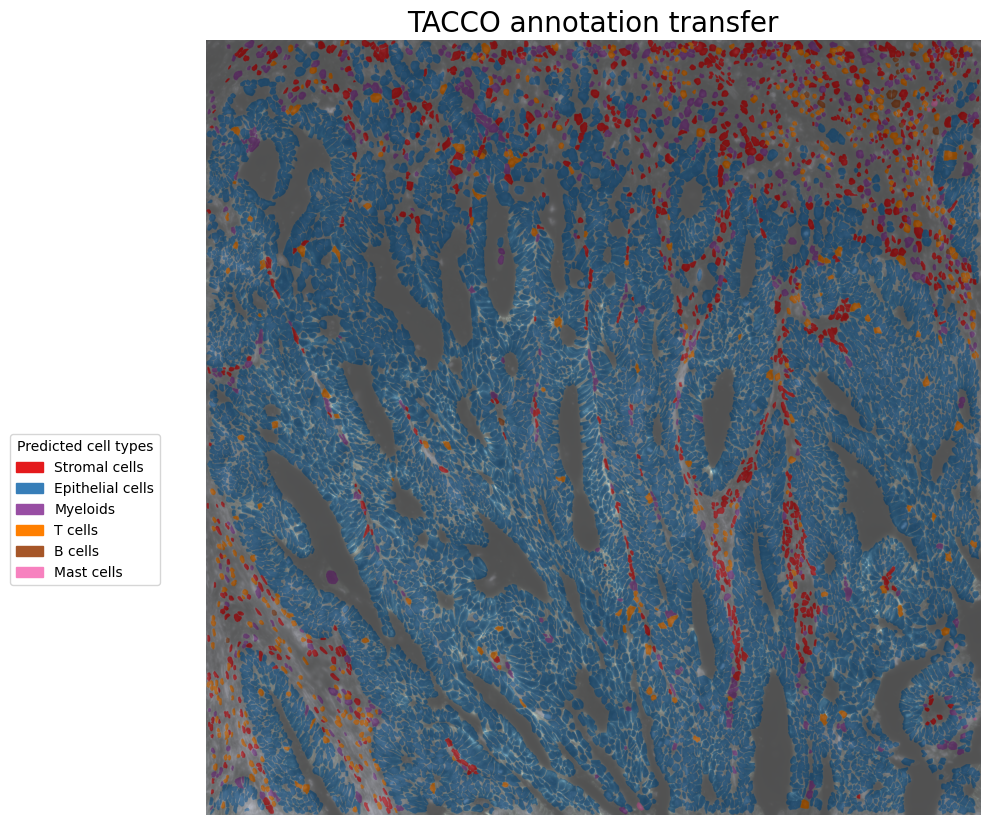

In [12]:
colormap = cm.Set1(np.linspace(0,1,len(np.unique(celltype_masks)-1)))

rgb_masks = color.label2rgb(celltype_masks, merged_image, colors=colormap, bg_label=0, bg_color=None, 
                             image_alpha=0.4, kind='overlay',saturation=0.1)
rgb_masks = exposure.rescale_intensity(rgb_masks)

fig,ax2 = plt.subplots(1,1)
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(10,10)
fig.subplots_adjust(bottom=0.1, right=0.9)
ax2.axis('off')

ax1.imshow(merged_image)
ax1.set_title('Colon cancer tile40')

ax2.imshow(rgb_masks)
ax2.set_title(f'{method.upper()} annotation transfer',fontsize=20)
handles = [mpatches.Patch(color=color, label=key) for color, key in zip(colormap,cell_types)]
ax2.legend(handles=handles,labels=cell_types,title='Predicted cell types',bbox_to_anchor=(1.05, 0.5))
fig.show()

In [68]:
all_markers=pd.read_csv('/media/gambino/students_workdir/ilias/data/markers/cellmarker_colon_markers.csv',delimiter=',').dropna()
all_markers = all_markers.loc[all_markers['Species'].str.contains('Hs|Human')]

In [69]:
markers_dict = {cell_type:{} for cell_type in cell_types}
markers_list = []
marker_groups = []
for cell_type in markers_dict:
    markers_dict[cell_type] = all_markers.loc[all_markers['Cell name'].str.contains(cell_type[:-1])].copy()

    markers_dict[cell_type] = markers_dict[cell_type][markers_dict[cell_type]['Cell marker']
                                                      .isin(andata.var.index)]
    if len(markers_dict[cell_type])>0:
        # markers_list.append(markers_dict[cell_type]['official gene symbol'].unique())
        markers_list.append(markers_dict[cell_type]['Cell marker'].unique())
        marker_groups.append(f'{cell_type} markers')

boundary_positions = np.cumsum([len(markers) for markers in markers_list])
boundary_positions = np.insert(boundary_positions, 0, 0)
group_index_intervals= np.array(list(zip(boundary_positions, boundary_positions[1:]-1)))

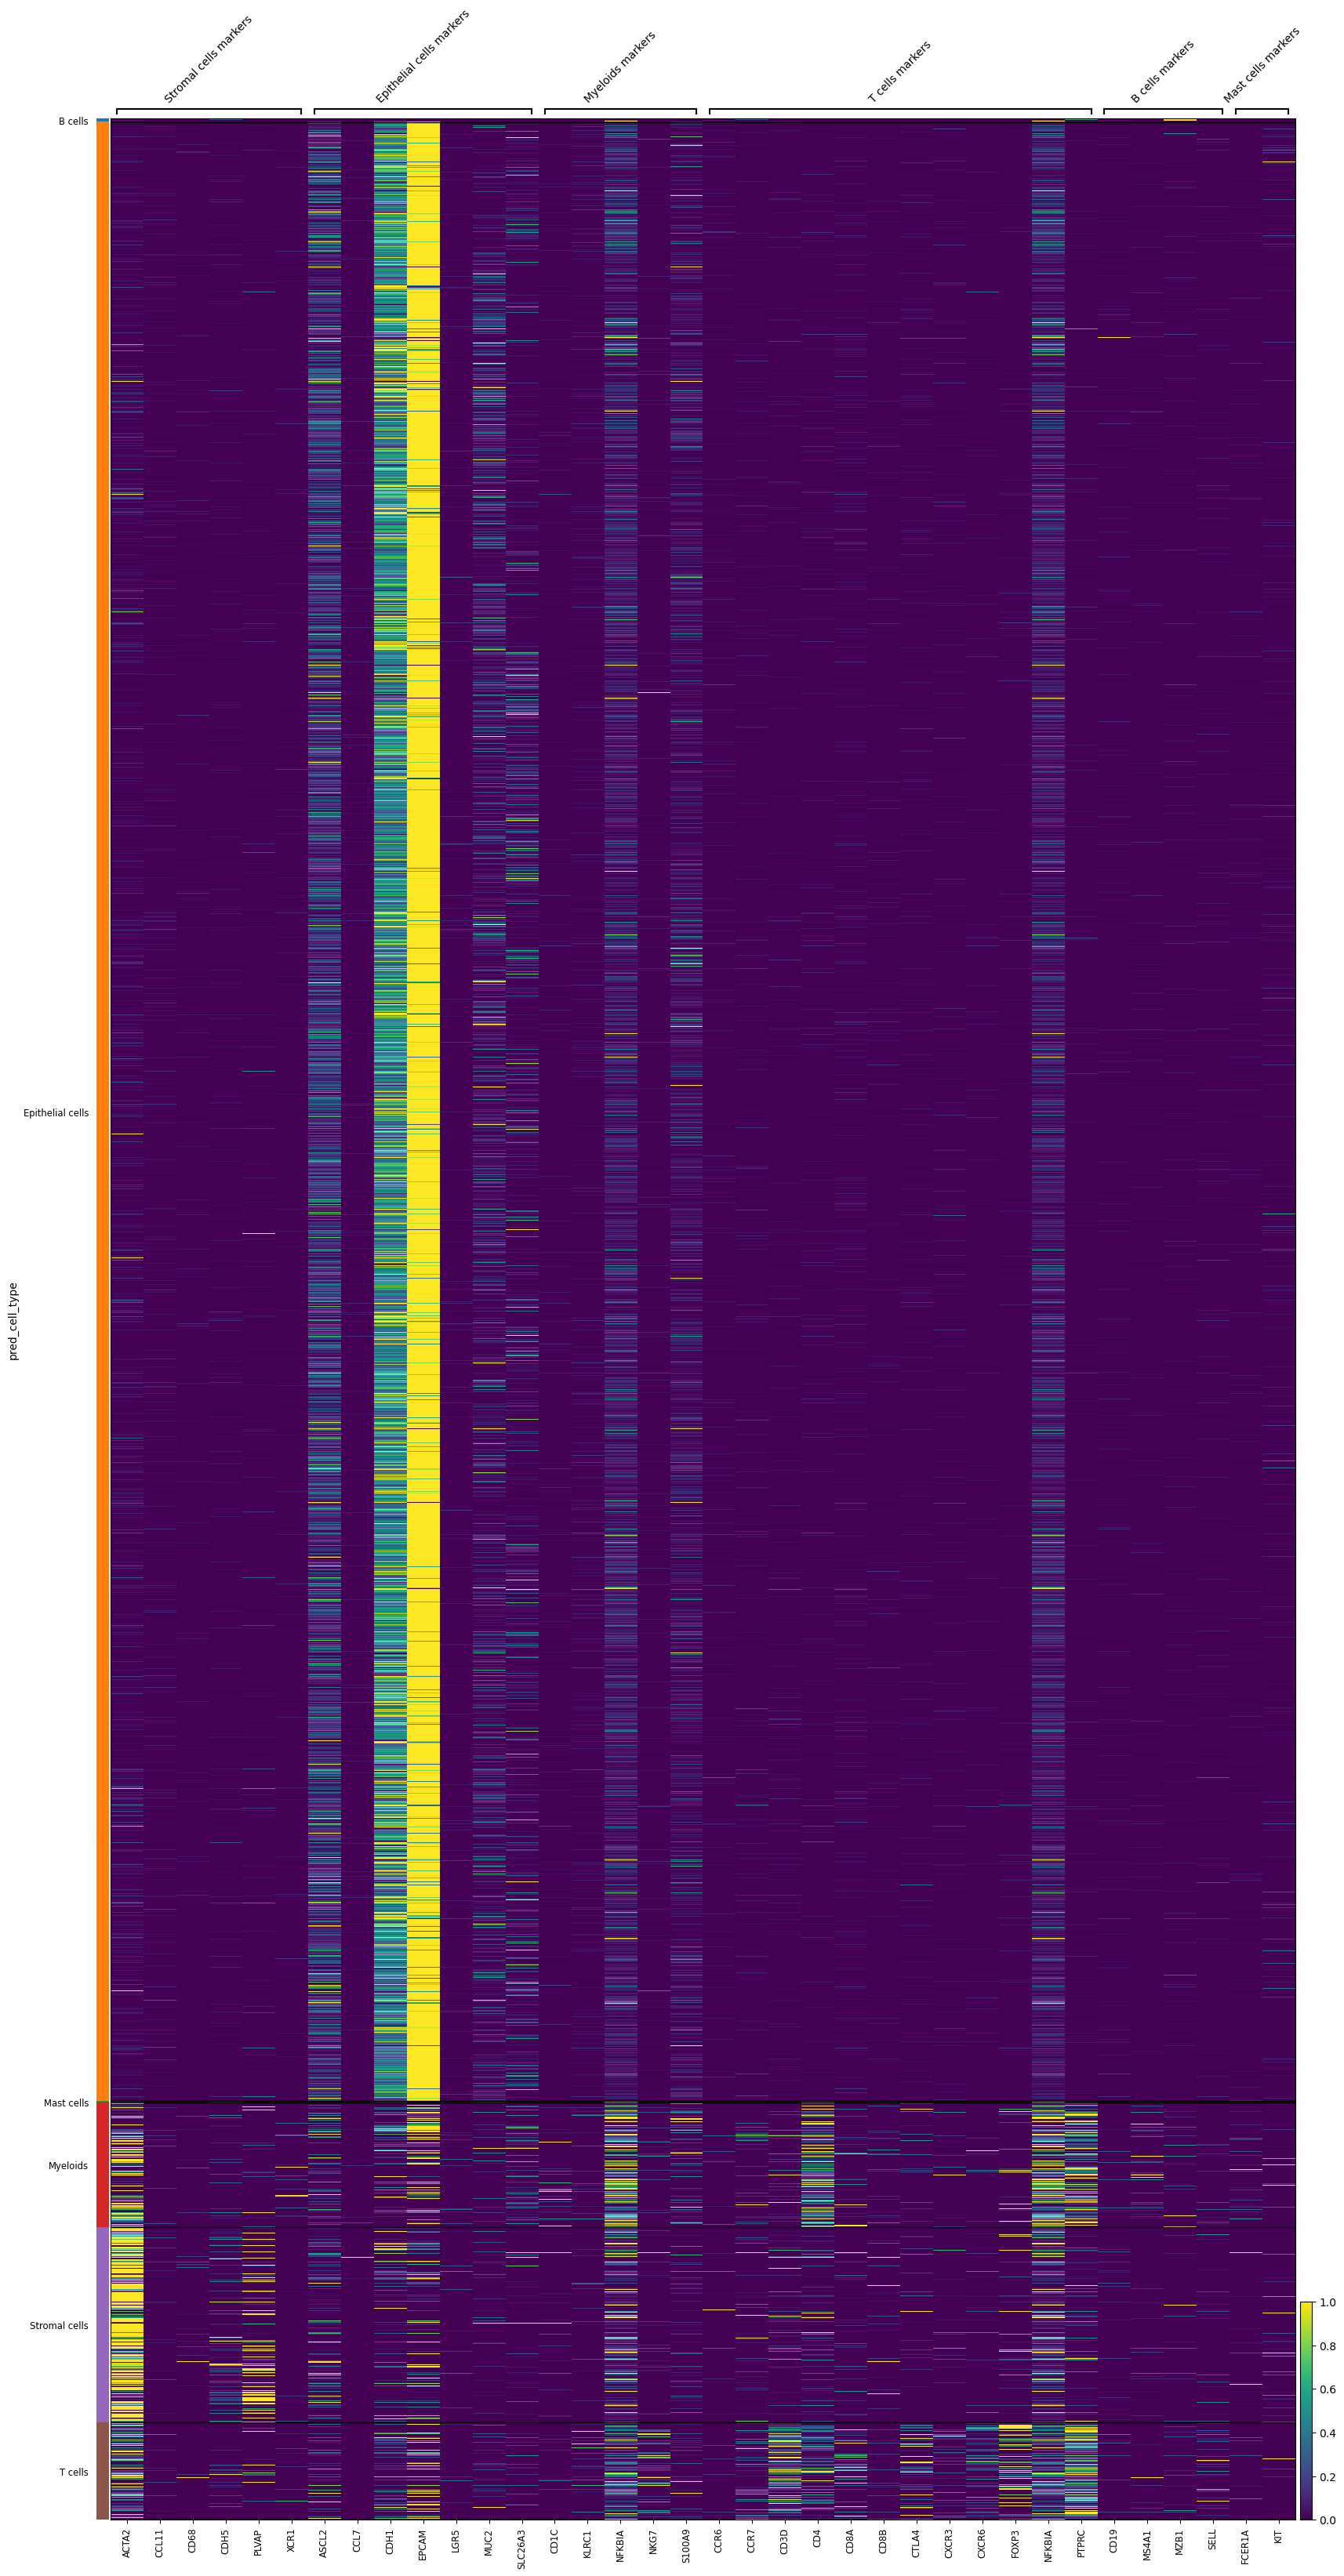

In [14]:
sc.pl.heatmap(andata, np.concatenate(markers_list),groupby='pred_cell_type',standard_scale='obs', show_gene_labels=True,
                    var_group_positions = group_index_intervals, var_group_rotation = 45,
                    var_group_labels = marker_groups,figsize=(20,40))

In [70]:
#TODO include more markers
selected_markers = ('EPCAM','CDH1','CD19','POU2AF1','CCL5','GZMA', 'ACTA2', 'CD1C')

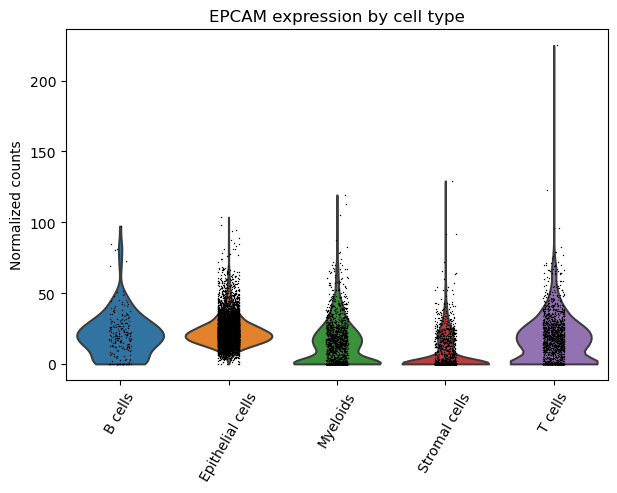

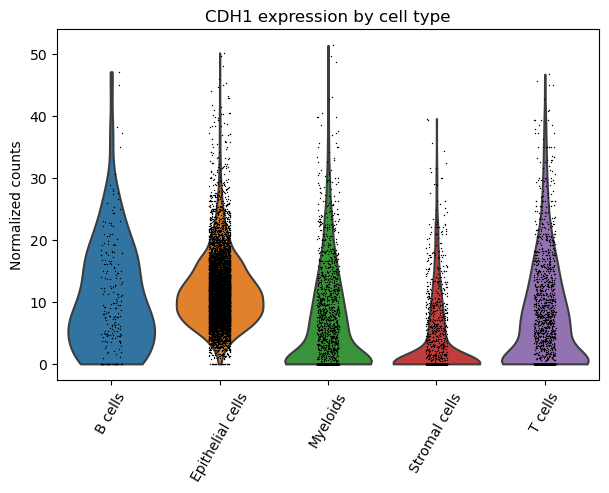

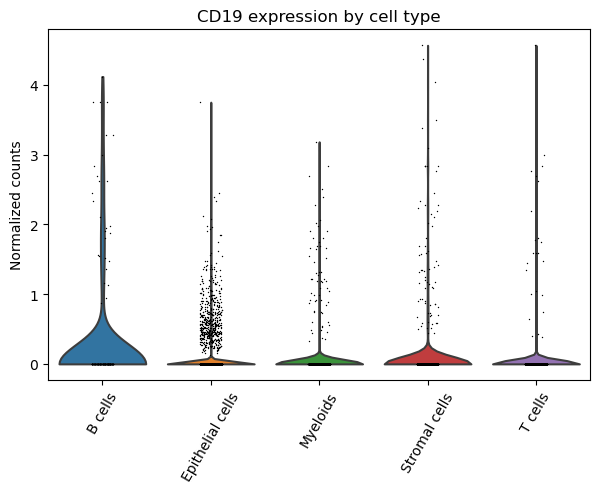

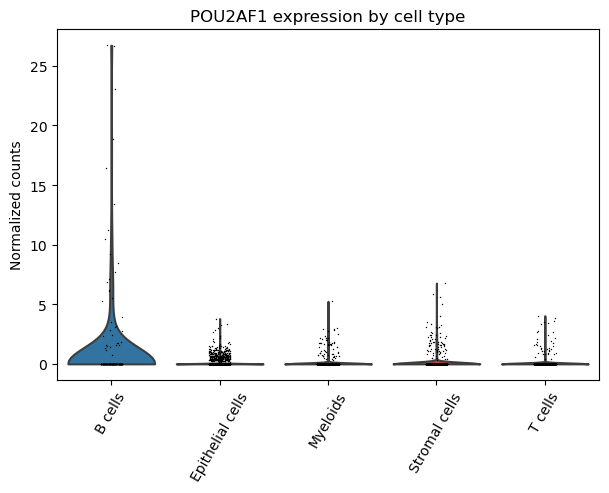

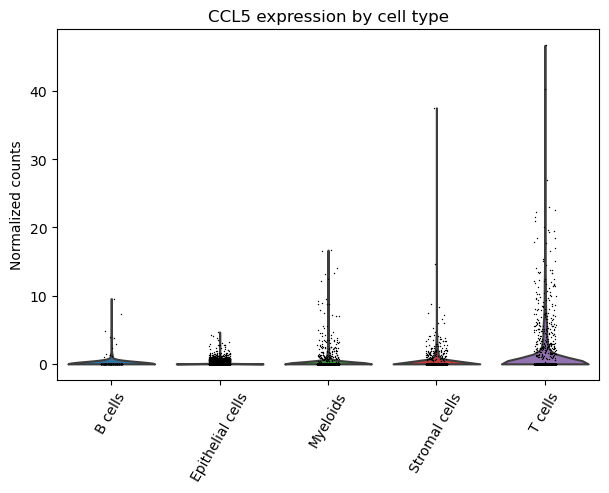

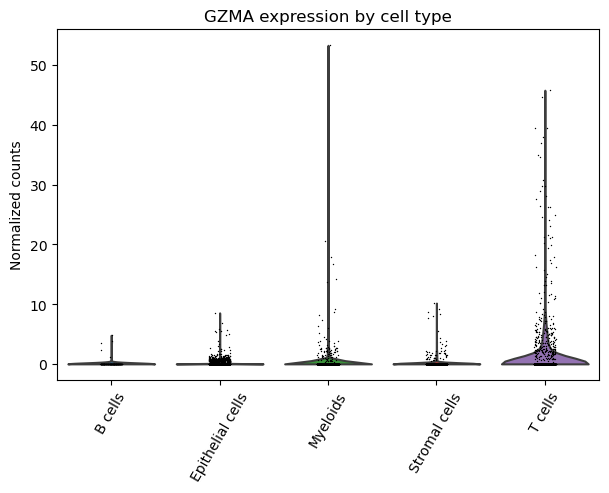

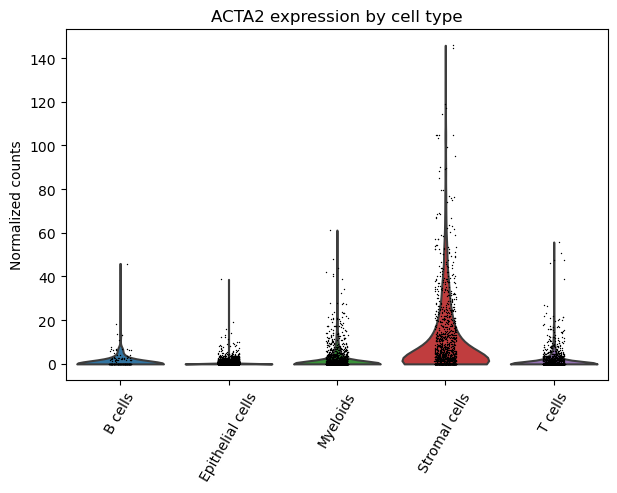

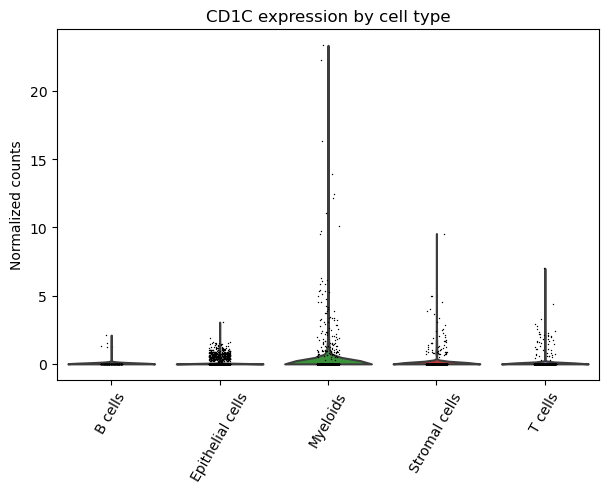

In [71]:
sc.pp.normalize_total(andata, exclude_highly_expressed=True)
for marker in selected_markers:
    ax = sc.pl.violin(andata, keys=marker, groupby='pred_cell_type',rotation=60, ylabel='Normalized counts',show=False)
    ax.set_title(f'{marker} expression by cell type')


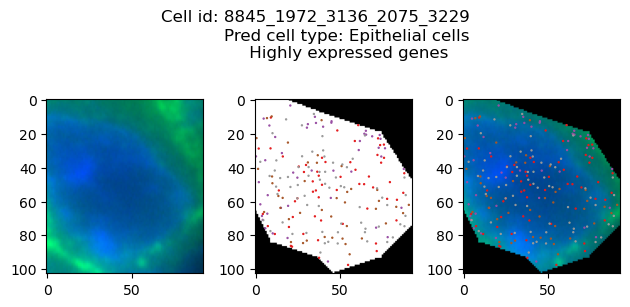

In [73]:
cell_index = 1242

PLOT_MARKERS = False

region_props = measure.regionprops_table(masks,properties=['image','bbox','label'])

cell_mask = region_props['image'][cell_index]
bbox_coords = [region_props[f'bbox-{i}'][cell_index] for i in range(4)]
cell_id  = f"{region_props['label'][cell_index]}_"+'_'.join([str(coord) for coord in bbox_coords])

#select transcripts assigned to this cell
cell_transcripts = transcript_coords[transcript_coords.loc[:,'mask_label']==region_props['label'][cell_index]].loc[:,['local_row','local_col','gene']]

#pred cell type
pred_cell_type = andata.obs.loc[cell_id,'pred_cell_type']

#Select highly expressed genes
sel_genes = andata.to_df().loc[cell_id,andata.to_df().loc[cell_id,:]>20].index

if PLOT_MARKERS:
    m1 = andata.to_df().loc[cell_id,np.concatenate(markers_list)]
    sel_genes = m1[m1!=0].index

cell_transcripts = cell_transcripts[cell_transcripts['gene'].str.lower().isin([gene.lower() for gene in sel_genes])]

#get global coordinates and transform them to local
transcript_global_coordinates = cell_transcripts[['local_row','local_col']].to_numpy()      #shape: (transcripts),(row,col)
transcript_global_coordinates = transcript_global_coordinates.swapaxes(0,1)                 #shape: (row,col),(transcripts)

transcript_row_coordinates = transcript_global_coordinates[0] - region_props['bbox-0'][cell_index]
transcript_col_coordinates = transcript_global_coordinates[1] - region_props['bbox-1'][cell_index]

cell_rgb_img = merged_image[bbox_coords[0]:bbox_coords[2],bbox_coords[1]:bbox_coords[3]]
cell_rgb_img = exposure.rescale_intensity(cell_rgb_img)

#Create color map
color_list = cm.Set1(np.linspace(0,1,len(sel_genes)))
gene_list = cell_transcripts['gene'].unique()
gene_colormap = dict(zip(gene_list,color_list))

fig,(ax1,ax2,ax3) = plt.subplots(1,3)
fig.suptitle(f'Cell id: {cell_id}\n\
            Pred cell type: {pred_cell_type}\n\
             {"Marker genes" if PLOT_MARKERS else "Highly expressed genes"}',
             y=0.8)

ax1.imshow(cell_rgb_img)

ax2.imshow(cell_mask,cmap='Greys_r')
ax2.scatter(transcript_col_coordinates,transcript_row_coordinates,s=0.5, c=cell_transcripts['gene'].map(gene_colormap))

ax3.imshow(cell_rgb_img*color.gray2rgb(cell_mask))
ax3.scatter(transcript_col_coordinates,transcript_row_coordinates,s=0.5, c=cell_transcripts['gene'].map(gene_colormap))

plt.tight_layout()
plt.show()

In [7]:
# Mean transcripts number per cell / mean (unique) transcripts per gene per cell
print(transcript_coords.groupby(['mask_label','gene']).count()['barcode_id'].groupby(['mask_label']).count().mean())
print(transcript_coords.groupby(['mask_label','gene']).count()['barcode_id'].groupby(['mask_label']).mean().mean())

130.906076445606
3.647818872808659


In [24]:
threshold = 40
num_points = 450

trans_coords_list, desc_list = [], []
region_props = measure.regionprops_table(masks,properties=['image','bbox','label'])

for cell_index in range(len(np.unique(masks))-1):
    bbox_coords = [region_props[f'bbox-{i}'][cell_index] for i in range(4)]
    cell_id  = f"{region_props['label'][cell_index]}_"+'_'.join([str(coord) for coord in bbox_coords])

    if cell_id in andata.obs.index:
        cell_transcripts = transcript_coords[transcript_coords.loc[:,'mask_label']==region_props['label'][cell_index]].loc[:,['local_row','local_col','gene']]

        counts = cell_transcripts['gene'].value_counts()
        filtered_transcripts = cell_transcripts[cell_transcripts['gene'].map(counts> threshold)]
        pred_cell_type = andata.obs.loc[cell_id,'pred_cell_type']
        pred_class =  andata.obs.loc[cell_id,'pred_class']

        for gene in filtered_transcripts['gene'].unique():
            transcript_row_coordinates = filtered_transcripts.loc[filtered_transcripts['gene']==gene,'local_row'] - region_props['bbox-0'][cell_index]
            transcript_col_coordinates = filtered_transcripts.loc[filtered_transcripts['gene']==gene,'local_col'] - region_props['bbox-1'][cell_index]
            
            trans_coords = np.vstack((transcript_row_coordinates, transcript_col_coordinates))

            padded = np.pad(trans_coords, ((0,0),(0,num_points - len(trans_coords[-1]))), 'constant', constant_values=(0,))
            mask = np.concatenate((np.ones(trans_coords.shape),
                                    np.zeros((trans_coords.shape[0],num_points - trans_coords.shape[1]))),
                                    axis=1)
            padded = np.concatenate((padded,np.expand_dims(mask[0],0)),axis=0)

            trans_coords_list.append(padded)
            desc_list.append([gene, pred_cell_type, pred_class, cell_id])

trans_coords_array = np.array(trans_coords_list)

In [29]:
desc_array = np.array(desc_list)
dataset = xarray.Dataset(data_vars = dict(trans_coords=(['index','coords','spots'], trans_coords_array),
                                          cell_masks= (['row','col'],masks)),
                        coords = dict(gene = (['index'], desc_array[:,0]),
                                      cell_type = (['index'], desc_array[:,1]),
                                      cell_id = (['index'], desc_array[:,3]),
                                        coords = (['row','col','mask'])))
dataset

<xarray.Dataset>
Dimensions:       (index: 16195, coords: 3, spots: 450, row: 10000, col: 10000)
Coordinates:
    gene          (index) <U26 'PKM' 'SOX9' 'PKM' ... 'EPCAM' 'CTNNB1' 'VEGFA'
    cell_type     (index) <U26 'Epithelial cells' ... 'Epithelial cells'
    cell_id       (index) <U26 '7597_37_3330_93_3396' ... '705143_8150_4151_8...
  * coords        (coords) <U4 'row' 'col' 'mask'
Dimensions without coordinates: index, spots, row, col
Data variables:
    trans_coords  (index, coords, spots) float64 14.09 16.4 6.282 ... 0.0 0.0
    cell_masks    (row, col) int32 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [30]:
dataset.to_netcdf(f'/media/gambino/students_workdir/ilias/colonCancerPatient2_tiles/tile40_z{z_stack}_dc_{method}_gene_expression_coords_masked.nc',engine='netcdf4')